In [2]:
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor, LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.grid_search import ParameterGrid

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
np.set_printoptions(precision=2)
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
pd.set_option('display.max_columns', 100) # Increase the number of columns available so they don't get cut off on the screen
pd.options.display.max_colwidth=100

In [3]:
# p_d_sales joins transaction records and customer demographics into one table
p_d_sales = pd.read_csv('trans_demographic.csv', quotechar='"', index_col='BASKET_ID', dtype= {'DAY': int, 'SALES_VALUE': np.float64, 'TRANS_TIME': int, 'WEEK_NO':int,'COUPON_DISC':int, 'SUM(QUANTITY)': int,'AGE_DESC':str,'MARITAL_STATUS_CODE': str,'INCOME_DESC':str, 'HOMEOWNER_DESC':str, 'HH_COMP_DESC':str,  'HOUSEHOLD_SIZE_DESC':str, 'KID_CATEGORY_DESC':str})
demo = pd.read_table('demographics.csv', delimiter=',')  # Customer demographics only
demo = demo.drop('household_key', axis=1)  # Household key not needed
agg_no_gas = pd.read_table('agg_no_gas.csv', delimiter=',')  # Trasaction list- grocery items only

# Clustering Demographic Data

In [4]:
from sklearn.cluster import KMeans, AgglomerativeClustering

In [5]:
d_dumm = pd.get_dummies(demo)

In [6]:
d_dumm[:5]

,AGE_DESC_19-24,AGE_DESC_25-34,AGE_DESC_35-44,AGE_DESC_45-54,AGE_DESC_55-64,AGE_DESC_65+,MARITAL_STATUS_CODE_A,MARITAL_STATUS_CODE_B,MARITAL_STATUS_CODE_U,INCOME_DESC_100-124K,INCOME_DESC_125-149K,INCOME_DESC_15-24K,INCOME_DESC_150-174K,INCOME_DESC_175-199K,INCOME_DESC_200-249K,INCOME_DESC_25-34K,INCOME_DESC_250K+,INCOME_DESC_35-49K,INCOME_DESC_50-74K,INCOME_DESC_75-99K,INCOME_DESC_Under 15K,HOMEOWNER_DESC_Homeowner,HOMEOWNER_DESC_Probable Owner,HOMEOWNER_DESC_Probable Renter,HOMEOWNER_DESC_Renter,HOMEOWNER_DESC_Unknown,HH_COMP_DESC_1 Adult Kids,HH_COMP_DESC_2 Adults Kids,HH_COMP_DESC_2 Adults No Kids,HH_COMP_DESC_Single Female,HH_COMP_DESC_Single Male,HH_COMP_DESC_Unknown,HOUSEHOLD_SIZE_DESC_1,HOUSEHOLD_SIZE_DESC_2,HOUSEHOLD_SIZE_DESC_3,HOUSEHOLD_SIZE_DESC_4,HOUSEHOLD_SIZE_DESC_5+,KID_CATEGORY_DESC_1,KID_CATEGORY_DESC_2,KID_CATEGORY_DESC_3+,KID_CATEGORY_DESC_None/Unknown
0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
2,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0
3,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0
4,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1


In [7]:
kmeans = KMeans(n_clusters=4, max_iter=500)
kmeans.fit(d_dumm)
#clusters = kmeans.predict(d_dumm)
demo['cluster'] = kmeans.fit_predict(d_dumm)

print "Number of Items Per Cluster:"
demo.cluster.value_counts()

Number of Items Per Cluster:


1    303
0    255
3    124
2    119
Name: cluster, dtype: int64

In [8]:
demo['is_0'] = demo.cluster==0
demo['is_1'] = demo.cluster==1
demo['is_2'] = demo.cluster==2
demo['is_3'] = demo.cluster==3

# Summarize the statistical characteristics of each cluster
demo.groupby("cluster").describe(include='all')
#demo.groupby("cluster").describe(include='all').to_csv('cluster_characteristics.csv')

AGE_DESC      HH_COMP_DESC HOMEOWNER_DESC HOUSEHOLD_SIZE_DESC  \
cluster                                                                        
0       count       255               255            255                 255   
        unique        6                 3              5                   1   
        top       45-54     Single Female        Unknown                   1   
        freq        103               111            135                 255   
        mean        NaN               NaN            NaN                 NaN   
        std         NaN               NaN            NaN                 NaN   
        min         NaN               NaN            NaN                 NaN   
        25%         NaN               NaN            NaN                 NaN   
        50%         NaN               NaN            NaN                 NaN   
        75%         NaN               NaN            NaN                 NaN   
        max         NaN               NaN            NaN                 NaN   
1       count       303               303            303                 303   
        unique        6                 4              5                   1   
        top       45-54  2 Adults No Kids      Homeowner                   2   
        freq        108               255            234                 303   
        mean        NaN               NaN            NaN                 NaN   
        std         NaN               NaN            NaN                 NaN   
        min         NaN               NaN            NaN                 NaN   
        25%         NaN               NaN            NaN                 NaN   
        50%         NaN               NaN            NaN                 NaN   
        75%         NaN               NaN            NaN                 NaN   
        max         NaN               NaN            NaN                 NaN   
2       count       119               119            119                 119   
        unique        5                 3              4                   2   
        top       35-44     2 Adults Kids      Homeowner                  5+   
        freq         43                99             95                  66   
        mean        NaN               NaN            NaN                 NaN   
        std         NaN               NaN            NaN                 NaN   
        min         NaN               NaN            NaN                 NaN   
        25%         NaN               NaN            NaN                 NaN   
        50%         NaN               NaN            NaN                 NaN   
        75%         NaN               NaN            NaN                 NaN   
        max         NaN               NaN            NaN                 NaN   
3       count       124               124            124                 124   
        unique        6                 3              4                   2   
        top       45-54     2 Adults Kids      Homeowner                   3   
        freq         40                88             78                 109   
        mean        NaN               NaN            NaN                 NaN   
        std         NaN               NaN            NaN                 NaN   
        min         NaN               NaN            NaN                 NaN   
        25%         NaN               NaN            NaN                 NaN   
        50%         NaN               NaN            NaN                 NaN   
        75%         NaN               NaN            NaN                 NaN   
        max         NaN               NaN            NaN                 NaN   

               INCOME_DESC KID_CATEGORY_DESC MARITAL_STATUS_CODE   is_0  \
cluster                                                                   
0       count          255               255                 255    255   
        unique          11                 1                   2    NaN   
        top         50-74K      No

In [9]:
aggcl = AgglomerativeClustering(n_clusters=5, linkage='ward')
aggcl.fit(d_dumm)
#clusters = kmeans.predict(d_dumm)
demo['agg_cluster'] = aggcl.fit_predict(d_dumm)
cl_size = demo.agg_cluster.value_counts()
print "Number of Items Per Cluster:"
cl_size

Number of Items Per Cluster:


0    255
4    179
3    126
2    124
1    117
Name: agg_cluster, dtype: int64

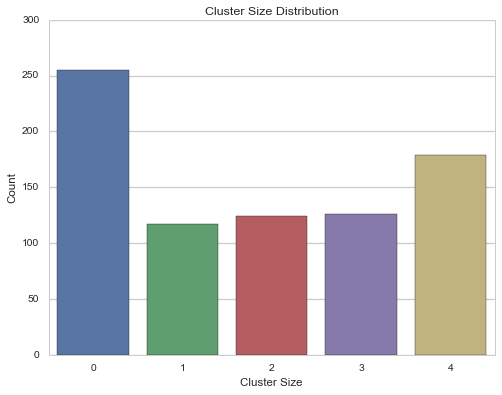

In [10]:
sns.set_context("talk", font_scale = 0.8)
plt.figure(figsize=(8, 6))
a = sns.countplot(x="agg_cluster", data=demo, order=[0,1,2,3,4])
sns.axlabel("Cluster Size", "Count")
a.axes.set_title('Cluster Size Distribution')
plt.savefig('cluster_size.png')

In [13]:
demo['agg_is_0'] = demo.agg_cluster==0
demo['agg_is_1'] = demo.agg_cluster==1
demo['agg_is_2'] = demo.agg_cluster==2
demo['agg_is_3'] = demo.agg_cluster==3
demo['agg_is_4'] = demo.agg_cluster==4
demo['agg_is_5'] = demo.agg_cluster==5
demo['agg_is_6'] = demo.agg_cluster==6

# Summarize the statistical characteristics of each cluster
demo.groupby("agg_cluster").describe(include='all')
#demo.groupby("agg_cluster").describe(include='all').to_csv('agg_cluster_characteristics_ward_k5.csv')

AGE_DESC      HH_COMP_DESC HOMEOWNER_DESC  \
agg_cluster                                                    
0           count       255               255            255   
            unique        6                 3              5   
            top       45-54     Single Female        Unknown   
            freq        103               111            135   
            mean        NaN               NaN            NaN   
            std         NaN               NaN            NaN   
            min         NaN               NaN            NaN   
            25%         NaN               NaN            NaN   
            50%         NaN               NaN            NaN   
            75%         NaN               NaN            NaN   
            max         NaN               NaN            NaN   
1           count       117               117            117   
            unique        5                 3              4   
            top       35-44     2 Adults Kids      Homeowner   
            freq         43                98             95   
            mean        NaN               NaN            NaN   
            std         NaN               NaN            NaN   
            min         NaN               NaN            NaN   
            25%         NaN               NaN            NaN   
            50%         NaN               NaN            NaN   
            75%         NaN               NaN            NaN   
            max         NaN               NaN            NaN   
2           count       124               124            124   
            unique        6                 1              4   
            top       45-54  2 Adults No Kids      Homeowner   
            freq         44               124             77   
            mean        NaN               NaN            NaN   
            std         NaN               NaN            NaN   
            min         NaN               NaN            NaN   
            25%         NaN               NaN            NaN   
            50%         NaN               NaN            NaN   
            75%         NaN               NaN            NaN   
            max         NaN               NaN            NaN   
3           count       126               126            126   
            unique        6                 3              4   
            top       45-54     2 Adults Kids      Homeowner   
            freq         40                89             78   
            mean        NaN               NaN            NaN   
            std         NaN               NaN            NaN   
            min         NaN               NaN            NaN   
            25%         NaN               NaN            NaN   
            50%         NaN               NaN            NaN   
            75%         NaN               NaN            NaN   
            max         NaN               NaN            NaN   
4           count       179               179            179   
            unique        6                 4              5   
            top       45-54  2 Adults No Kids      Homeowner   
            freq         64               131            157   
            mean        NaN               NaN            NaN   
            std         NaN               NaN            NaN   
            min         NaN               NaN            NaN   
            25%         NaN               NaN            NaN   
            50%         NaN               NaN            NaN   
            75%         NaN               NaN            NaN   
            max         NaN               NaN            NaN   

                   HOUSEHOLD_SIZE_DESC INCOME_DESC KID_CATEGORY_DESC  \
agg_cluster                                                            
0           count                  255         255               255   
            unique                   1          11                 1   
            top                      1      50-74K      None/Unknown   
          